<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# import common libraries
%load_ext autoreload
%autoreload 2

#%matplotlib notebook
%matplotlib inline

# this is to install lightgbm
#import sys
#!{sys.executable} -m pip install lightgbm

import os
import os.path
import numpy as np
import lightgbm

In [2]:
# A more reasonable setting: train/valid/test

import itertools
from sklearn.datasets import load_svmlight_file
# see http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html


train_file = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/train.txt"
valid_file = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/vali.txt"
test_file  = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/test.txt"

# train
raw_data = load_svmlight_file(train_file, query_id=True)
query_lens = [ sum( 1 for _ in group ) for key, group in itertools.groupby( raw_data[2] )  ]
train_lgb = lightgbm.Dataset(data=raw_data[0], label=raw_data[1], group=query_lens)

# valid
raw_data = load_svmlight_file(valid_file, query_id=True)
query_lens = [ sum( 1 for _ in group ) for key, group in itertools.groupby( raw_data[2] )  ]
valid_lgb = lightgbm.Dataset(data=raw_data[0], label=raw_data[1], group=query_lens)

# test
raw_data = load_svmlight_file(test_file, query_id=True)
query_lens = [ sum( 1 for _ in group ) for key, group in itertools.groupby( raw_data[2] )  ]
test_lgb = lightgbm.Dataset(data=raw_data[0], label=raw_data[1], group=query_lens)


In [3]:
# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, value: array, is_higher_better: bool
def mse_eval(preds, train_data):
    labels = train_data.get_label()
    
    avg_mse = 0.5 * np.mean( (labels-preds)**2 )
    
    return 'Custom-MSE', avg_mse, False

# self-defined objective function
# f(preds: array, train_data: Dataset) -> grad: array, hess: array
def mse_grads(preds, train_data):
    labels = train_data.get_label()
    #grad = labels - preds # this is the neg grad !!!
    grad = preds - labels
    hess = np.ones_like(grad)
    return grad, hess

[1]	train's Custom-MSE: 0.509403	valid's Custom-MSE: 0.523649	test's Custom-MSE: 0.526099
[2]	train's Custom-MSE: 0.468913	valid's Custom-MSE: 0.482435	test's Custom-MSE: 0.484615
[3]	train's Custom-MSE: 0.436149	valid's Custom-MSE: 0.449052	test's Custom-MSE: 0.451116
[4]	train's Custom-MSE: 0.409289	valid's Custom-MSE: 0.421708	test's Custom-MSE: 0.42365
[5]	train's Custom-MSE: 0.38743	valid's Custom-MSE: 0.399419	test's Custom-MSE: 0.401174
[6]	train's Custom-MSE: 0.369535	valid's Custom-MSE: 0.381075	test's Custom-MSE: 0.382687
[7]	train's Custom-MSE: 0.354743	valid's Custom-MSE: 0.365983	test's Custom-MSE: 0.36744
[8]	train's Custom-MSE: 0.34275	valid's Custom-MSE: 0.353703	test's Custom-MSE: 0.355038
[9]	train's Custom-MSE: 0.33282	valid's Custom-MSE: 0.343475	test's Custom-MSE: 0.344757
[10]	train's Custom-MSE: 0.324612	valid's Custom-MSE: 0.335042	test's Custom-MSE: 0.336268
[11]	train's Custom-MSE: 0.317843	valid's Custom-MSE: 0.328103	test's Custom-MSE: 0.329287
[12]	train's 

[92]	train's Custom-MSE: 0.271995	valid's Custom-MSE: 0.282809	test's Custom-MSE: 0.284356
[93]	train's Custom-MSE: 0.271911	valid's Custom-MSE: 0.282752	test's Custom-MSE: 0.284303
[94]	train's Custom-MSE: 0.271851	valid's Custom-MSE: 0.282697	test's Custom-MSE: 0.284259
[95]	train's Custom-MSE: 0.271775	valid's Custom-MSE: 0.282643	test's Custom-MSE: 0.284233
[96]	train's Custom-MSE: 0.271702	valid's Custom-MSE: 0.282606	test's Custom-MSE: 0.284172
[97]	train's Custom-MSE: 0.271618	valid's Custom-MSE: 0.282552	test's Custom-MSE: 0.284134
[98]	train's Custom-MSE: 0.271496	valid's Custom-MSE: 0.282491	test's Custom-MSE: 0.284065
[99]	train's Custom-MSE: 0.271386	valid's Custom-MSE: 0.282466	test's Custom-MSE: 0.284053
[100]	train's Custom-MSE: 0.271326	valid's Custom-MSE: 0.282435	test's Custom-MSE: 0.284036


Text(0.5, 1.0, 'Model Error')

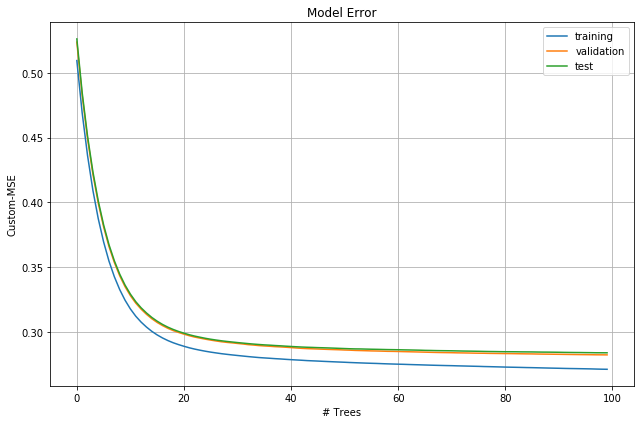

In [4]:
params = {
#    'objective':'lambdarank', # what to optimize during training
#    'max_position': 10,      # threshold used in optimizing lamdarank (NDCG)
    'learning_rate': 0.1,
    'num_leaves': 16,
    'min_data_in_leaf': 5,
    'metric': ['None'], #['ndcg'],       # what to use/print for evaluation
#    'ndcg_eval_at': 10
# try printing ndcg and testing
}    

lgbm_info = {}

lgbm_model = lightgbm.train(params, train_lgb, num_boost_round=100,
                            feval = mse_eval,
                            fobj  = mse_grads,
                            valid_sets   = [train_lgb, valid_lgb, test_lgb], 
                            valid_names  = ["train", "valid", "test"],
                            evals_result = lgbm_info,
                            verbose_eval = 1)


#lgbm_info

import matplotlib.pyplot as plt

plt.figure(figsize=(9,6), tight_layout=True)

plt.plot(lgbm_info['train']['Custom-MSE'], label='training')
plt.plot(lgbm_info['valid']['Custom-MSE'], label='validation')
plt.plot(lgbm_info['test']['Custom-MSE'], label='test')

plt.grid()
plt.legend()
plt.xlabel("# Trees")
plt.ylabel("Custom-MSE")
plt.title("Model Error")